In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt

In [34]:
def clean_columns(df):
    new_column_names = {old:re.sub( string=old.lower()
                                   ,pattern='\W' #\W matches non-alphnumeric
                                   ,repl='_')\
                              .strip('_')
                        for old in df.columns
                       }
    return (df.rename(columns=new_column_names))

In [3]:
def date_columns(df):
    for date_column in df.filter(regex=("date")).columns:
        df[date_column] = pd.to_datetime(df[date_column])
    return df    

In [4]:
def zero_to_null(df,list_of_columns):
    for column in list_of_columns:
        df[column] = df[column].apply(lambda x: x if x != 0 else np.nan)
    return df

In [5]:
def merge_multi(self, df, on):
    return self.reset_index().merge(df.reset_index(),on=on,how='left').set_index(self.index.names)

pd.DataFrame.merge_multi = merge_multi

In [32]:
casing = date_columns(clean_columns(pd.concat([ pd.read_csv('./data/welldatabase/2017-20181261020/2017-20181261020-Casing.csv')
                                               ,pd.read_csv('./data/welldatabase/2018-20181041440/2018-20181041440-Casing.csv')
                                              ]
                                             )))


completion = date_columns(clean_columns(pd.concat([ pd.read_csv('./data/welldatabase/2017-20181261020/2017-20181261020-Completion.csv')
                                                   ,pd.read_csv('./data/welldatabase/2018-20181041440/2018-20181041440-Completion.csv')
                                                  ]
                                                 )))

directional = date_columns(clean_columns(pd.concat([pd.read_csv('./data/welldatabase/2017-20181261020/2017-20181261020-Directional.csv')
                                                    ,pd.read_csv('./data/welldatabase/2018-20181041440/2018-20181041440-Directional.csv')
                                                   ]
                                                  )))

formation = date_columns(clean_columns(pd.concat([pd.read_csv('./data/welldatabase/2017-20181261020/2017-20181261020-Formation.csv')
                                                  ,pd.read_csv('./data/welldatabase/2018-20181041440/2018-20181041440-Formation.csv')
                                                 ]
                                                )))

fracstage = date_columns(clean_columns( pd.concat([pd.read_csv('./data/welldatabase/2017-20181261020/2017-20181261020-FracStage.csv')
                                                   ,pd.read_csv('./data/welldatabase/2018-20181041440/2018-20181041440-FracStage.csv')
                                                  ]
                                                 )))

header = date_columns(clean_columns(pd.concat([pd.read_csv('./data/welldatabase/2017-20181261020/2017-20181261020-Header.csv')
                                               ,pd.read_csv('./data/welldatabase/2018-20181041440/2018-20181041440-Header.csv')
                                              ]
                                             )))

perf = date_columns(clean_columns(pd.concat([pd.read_csv('./data/welldatabase/2017-20181261020/2017-20181261020-Perf.csv')
                                             ,pd.read_csv('./data/welldatabase/2018-20181041440/2018-20181041440-Perf.csv')
                                            ]
                                           )))

production = date_columns(clean_columns(pd.concat([pd.read_csv('./data/welldatabase/2017-20181261020/2017-20181261020-Production.csv')
                                                   ,pd.read_csv('./data/welldatabase/2018-20181041440/2018-20181041440-Production.csv')
                                                  ]
                                                 )))

productionsummary = date_columns(clean_columns(pd.concat([pd.read_csv('./data/welldatabase/2017-20181261020/2017-20181261020-ProductionSummary.csv')
                                                          ,pd.read_csv('./data/welldatabase/2018-20181041440/2018-20181041440-ProductionSummary.csv')
                                                         ]
                                                        )))

test = date_columns(clean_columns(pd.concat([pd.read_csv('./data/welldatabase/2017-20181261020/2017-20181261020-Test.csv')
                                             ,pd.read_csv('./data/welldatabase/2018-20181041440/2018-20181041440-Test.csv')
                                            ]
                                           )))

tubingandpacker = date_columns(clean_columns(pd.concat([pd.read_csv('./data/welldatabase/2017-20181261020/2017-20181261020-TubingAndPacker.csv')
                                                        ,pd.read_csv('./data/welldatabase/2018-20181041440/2018-20181041440-TubingAndPacker.csv')                                         ]
                                                      )))


In [7]:
header = header[header['wellboreprofile']=='HORIZONTAL']
sqdist = (header['surfacelatitude']-header['bottomholelatitude'])**2 + (header['surfacelongitude']-header['bottomholelongitude'])**2
header['surface_to_bottomhole_distance'] = sqdist.map(lambda x: np.sqrt(x))

In [8]:
linear_reg = LinearRegression()
xy=header.loc[header['surface_to_bottomhole_distance']!=0,['laterallength','surface_to_bottomhole_distance']].dropna()
y = xy['laterallength'].values.reshape(-1, 1)
X = xy['surface_to_bottomhole_distance'].values.reshape(-1, 1)
linear_reg.fit(X=X,y=y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

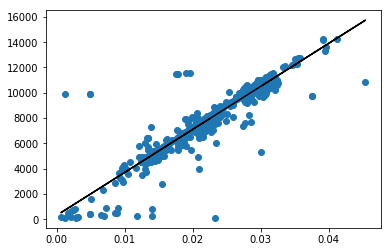

In [9]:
plt.plot( X ,y ,'o'
         ,X,linear_reg.predict(X),'-k')

In [10]:
header['laterallength_from_bottom'] = linear_reg.predict(header['surface_to_bottomhole_distance'].values.reshape(-1, 1))

In [11]:
header['missing_laterallength'] =  header['laterallength'].isnull()

In [12]:
header_summary = header.groupby('api').agg({ 'wellname':'first'
                                            ,'lease':'first'                          
                                            ,'surfacelatitude':'max'
                                            ,'surfacelongitude':'max'
                                            ,'bottomholelatitude':'max'
                                            ,'bottomholelongitude':'max'  
                                            ,'surface_to_bottomhole_distance':'max'
                                            ,'laterallength_from_bottom':'max'
                                            ,'missing_laterallength':'all'
                                            ,'county':'first'
                                            ,'state':'first'
                                            ,'currentoperator':'first'
                                            ,'originaloperator':'first'
                                            ,'producingformation':'first'
                                            ,'wellboreprofile':'first'
                                            ,'totaldepth':'max'
                                            ,'trueverticaldepth':'max'
                                            ,'laterallength':'max'
                                            ,'dfelevation':'max'
                                            ,'glelevation':'max'
                                            ,'kbelevation':'max'
                                            ,'firstproddate':'first'
                                            ,'permitdate':'first'
                                            ,'spuddate':'first'                          
                                            }
                                          )

In [13]:
completion = zero_to_null(completion,['upperperf','lowerperf'])

In [14]:
completion_summary = completion.groupby(['api','completiondate']).agg({'formation':'first'
                                                                       ,'upperperf':'max'
                                                                       ,'upperperftvd':'max'
                                                                       ,'lowerperf':'max'
                                                                       ,'lowerperftvd':'max'
                                                                       ,'ipoil':'max'
                                                                       ,'ipgas':'max'
                                                                       ,'ipwater':'max'
                                                                      })

In [15]:
index_of_deepest_top = formation.groupby("api").agg({'topdepth':'idxmax'})['topdepth'].dropna()
formation_summary = formation.iloc[index_of_deepest_top].groupby('api').agg({'name':'first'})

In [16]:
fracstage_summary = fracstage.groupby('api').agg({ 'fracstart': 'first'
                                                  , 'fracend': 'first'
                                                  , 'operatorname': 'first'                              
                                                  , 'totalbasewatervolume': 'first'
                                                  , 'totalfracmass': 'first'
                                                  , 'totalproppantmass': 'first'
                                                  , 'fluidsystem': 'first'
                                                  , 'proppantmaterial': 'first'
                                                  , 'crosslinkfluid': 'first'
                                                  , 'surfactantpresent': 'first'
                                                  , 'scaleinhibitorpresent': 'first'
                                                  , 'claycontrolpresent': 'first'
                                                  , 'claycontrolagent': 'first'
                                                  , 'acidtreatmentpresent': 'first'}
                                                )

In [17]:
perf = zero_to_null(perf,['lowerperf','upperperf'])

In [18]:
perf_summary = perf.groupby('api').agg({'lowerperf':'min'
                                        ,'upperperf':'max'
                                       }
                                      )

In [19]:
production['yearmonth'] = production['date'].apply(lambda x: '{YEAR}-{MONTH:02d}'.format(YEAR=x.year,MONTH=x.month))

In [20]:
production['days'] = pd.to_timedelta(production['days'],unit='D')
production['first_producing_day_of_month'] = production['date'] + pd.DateOffset(months=1) - production['days']

In [21]:
production_summary = production.groupby(['api','yearmonth']).agg({ 'first_producing_day_of_month':'first'
                                                                  ,'oil':'max'
                                                                  ,'gas':'max'
                                                                  ,'water':'max'
                                                                  ,'state':'first'
                                                                  ,'county':'first'
                                                                  ,'field':'first'
                                                                  ,'operator':'first'
                                                                  ,'days':'max'
                                                                  ,'dailyoil':'max'
                                                                  ,'dailygas':'max'
                                                                  ,'dailywater':'max'                                             
                                                                 })

In [22]:
test_summary = test.groupby(['api','testdate']).agg({'chokesize':'first'
                                                     ,'liftingmethod':'first'
                                                     ,'meterpressure':'first'
                                                     ,'mixturegravity':'first'
                                                     ,'oilgravity':'first'
                                                     ,'shutinpressure':'first'
                                                     ,'shutintemp':'first'
                                                     ,'stateid':'first'                                                                            
                                                    }
                                                   )

In [23]:
productionsummary_summary = productionsummary.groupby('api').agg({'firsttwelvemonthboe': 'max'                                      
                                                                  , 'firsttwelvemonthgas': 'max'
                                                                  , 'firsttwelvemonthoil': 'max'
                                                                  , 'firsttwelvemonthwater': 'max'
                                                                  , 'ipgas': 'max'
                                                                  , 'ipoil': 'max'
                                                                  , 'reservoir': 'first'
                                                                 }
                                                                )


In [24]:
combined = header_summary.join(productionsummary_summary)\
                         .join(perf_summary)\
                         .join(fracstage_summary)\
                         .merge_multi(test_summary,on='api')\
                         .merge_multi(completion_summary,on='api')\
                         .merge_multi(production_summary,on='api')

In [25]:
combined['days_since_completion'] = ( combined['first_producing_day_of_month'] - combined['completiondate'] ) / np.timedelta64(1, 'D')

In [26]:
combined['increment_30days'] = combined['days_since_completion'].apply(lambda x: np.floor(x / 30) + 1)

In [27]:
combined = combined[combined['first_producing_day_of_month'] >= combined['completiondate']]

In [28]:
{index:value for (index, value) in combined.dtypes.iteritems()}

{'acidtreatmentpresent': dtype('O'),
 'bottomholelatitude': dtype('float64'),
 'bottomholelongitude': dtype('float64'),
 'chokesize': dtype('O'),
 'claycontrolagent': dtype('O'),
 'claycontrolpresent': dtype('O'),
 'completiondate': dtype('<M8[ns]'),
 'county_x': dtype('O'),
 'county_y': dtype('O'),
 'crosslinkfluid': dtype('O'),
 'currentoperator': dtype('O'),
 'dailygas': dtype('float64'),
 'dailyoil': dtype('float64'),
 'dailywater': dtype('float64'),
 'days': dtype('<m8[ns]'),
 'days_since_completion': dtype('float64'),
 'dfelevation': dtype('int64'),
 'field': dtype('O'),
 'first_producing_day_of_month': dtype('<M8[ns]'),
 'firstproddate': dtype('<M8[ns]'),
 'firsttwelvemonthboe': dtype('float64'),
 'firsttwelvemonthgas': dtype('float64'),
 'firsttwelvemonthoil': dtype('float64'),
 'firsttwelvemonthwater': dtype('float64'),
 'fluidsystem': dtype('O'),
 'formation': dtype('O'),
 'fracend': dtype('O'),
 'fracstart': dtype('O'),
 'gas': dtype('float64'),
 'glelevation': dtype('int64'

In [29]:
combined.groupby(['api','increment_30days']).agg('sum')

surfacelatitude  surfacelongitude  \
api            increment_30days                                      
3001542732     2.0                     32.298332       -104.204849   
               3.0                     32.298332       -104.204849   
               7.0                     64.596664       -208.409698   
               12.0                    32.298332       -104.204849   
               13.0                    32.298332       -104.204849   
               40.0                    32.298332       -104.204849   
               41.0                    32.298332       -104.204849   
3001542733     3.0                     32.307613       -104.204597   
               4.0                     32.307613       -104.204597   
               7.0                     32.307613       -104.204597   
               8.0                     32.307613       -104.204597   
               12.0                    32.307613       -104.204597   
               13.0                    32.307613       -104.204597   
               40.0                    32.307613       -104.204597   
               41.0                    32.307613       -104.204597   
3001543097     12.0                    32.268032       -104.067612   
               13.0                    32.268032       -104.067612   
               32.0                    32.268032       -104.067612   
               33.0                    32.268032       -104.067612   
3001543520     1.0                     32.867809       -103.869263   
               2.0                     32.867809       -103.869263   
               25.0                    32.867809       -103.869263   
               26.0                    32.867809       -103.869263   
3001543544     1.0                     32.025742       -103.543442   
               12.0                    32.025742       -103.543442   
               13.0                    64.051483       -207.086884   
               25.0                    32.025742       -103.543442   
               26.0                    32.025742       -103.543442   
               27.0                    32.025742       -103.543442   
3001543555     1.0                     32.289570       -104.180084   
...                                          ...               ...   
33061041270000 2.0                     47.935375       -102.554108   
33061041280000 1.0                     47.935379       -102.554314   
               2.0                     47.935379       -102.554314   
33105025890000 1.0                     48.225040       -103.774673   
33105025900000 2.0                     48.224972       -103.774673   
33105040880000 1.0                     48.458599       -103.530518   
               2.0                     48.458599       -103.530518   
33105040890000 1.0                     48.458599       -103.530312   
33105041300000 1.0                     48.459015       -103.522827   
               2.0                     48.459015       -103.522827   
33105042840000 1.0                     48.459015       -103.522827   
33105042850000 1.0                     48.458599       -103.530418   
               2.0                     48.458599       -103.530418   
33105042860000 1.0                     48.458599       -103.530205   
               2.0                     48.458599       -103.530205   
33105044560000 2.0                     48.139194       -103.425568   
               3.0                     48.139194       -103.425568   
35011237480000 1.0                     35.725853        -98.505928   
35011238050000 4.0                     71.193542       -196.843307   
               1438.0                  71.193542       -196.843307   
35011238490000 1.0                     35.680889        -98.524551   
35039224950000 8.0                     35.711700        -98.722359   
               9.0                     35.711700        -98.722359   
               1437.0                  35.711700        -98.722359   
               1438.0                  35.7

In [30]:
combined.to_csv('./data/welldb_combined.csv')